In [277]:
import treetime
import time
import datetime
from dateutil import parser

[SeqRecord(seq=Seq('TTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA...GTG'), id='hCoV-19/Poland/NIPH-NIH_ECDC-021/2021', name='hCoV-19/Poland/NIPH-NIH_ECDC-021/2021', description='hCoV-19/Poland/NIPH-NIH_ECDC-021/2021', dbxrefs=[]), SeqRecord(seq=Seq('ACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...AAC'), id='hCoV-19/Poland/NIPH-NIH_ECDC-001/2021', name='hCoV-19/Poland/NIPH-NIH_ECDC-001/2021', description='hCoV-19/Poland/NIPH-NIH_ECDC-001/2021', dbxrefs=[]), SeqRecord(seq=Seq('AACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGT...TGC'), id='hCoV-19/Poland/NIPH-NIH_ECDC-223/2021', name='hCoV-19/Poland/NIPH-NIH_ECDC-223/2021', description='hCoV-19/Poland/NIPH-NIH_ECDC-223/2021', dbxrefs=[]), SeqRecord(seq=Seq('TTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGT...TCT'), id='hCoV-19/Poland/NIPH-NIH_ECDC-471/2021', name='hCoV-19/Poland/NIPH-NIH_ECDC-471/2021', description='hCoV-19/Poland/NIPH-NIH_ECDC-471/2021', dbxrefs=[]), SeqRecord(seq=Seq('ACCAACCAACTTTCGATCTCTTGT

FileNotFoundError: [Errno 2] No such file or directory: 'plots/tree5.svg'

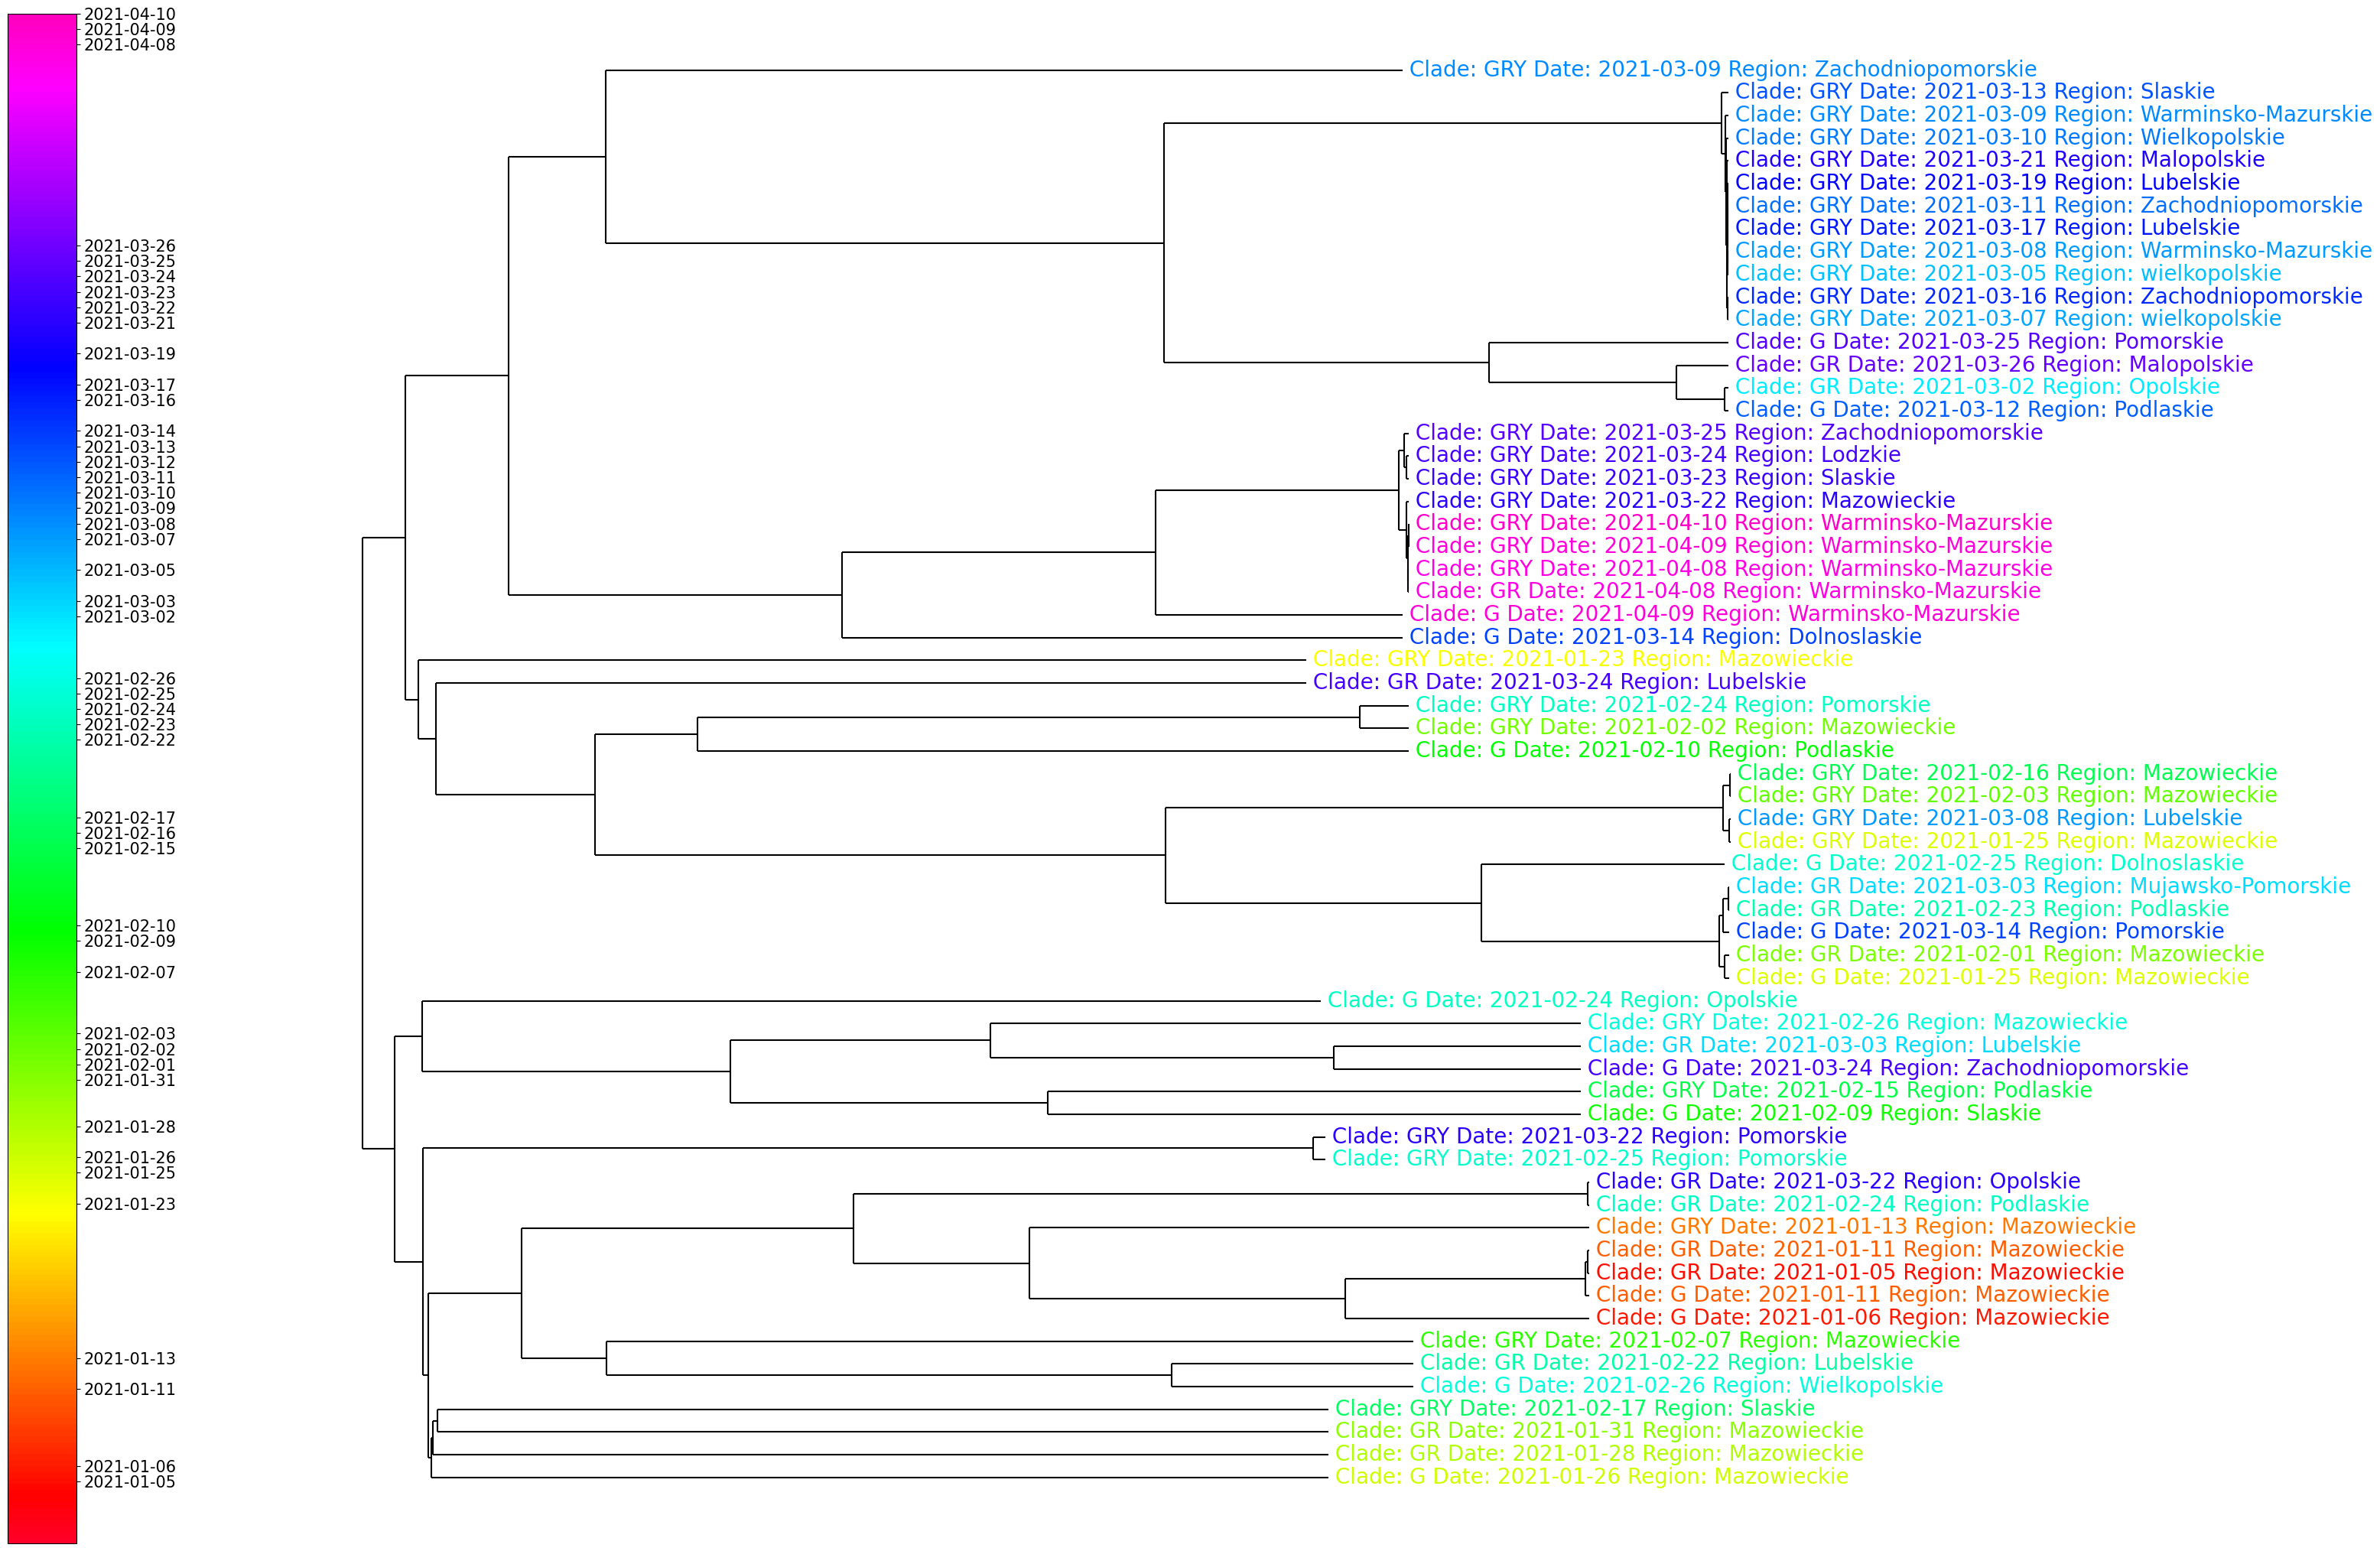

In [16]:
from Bio import Phylo, SeqIO, AlignIO, Seq
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import networkx
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import os
import pandas as pd
import numpy as np
from Bio.Phylo import PhyloXMLIO
import pickle
import datetime


clades = ["G", "GR", "GRY"]
records = []
clades_names = []
metadata = pd.DataFrame()
for clade in clades:
    input_dir = '../../data/project/clade_{}'.format(clade)
    files = os.listdir(input_dir)
    for f in files:
        if f.endswith(".fasta"):
            recs = SeqIO.parse(os.path.join(input_dir, f), 'fasta')
            r = list(recs)
            clades_names = clades_names + [clade] * len(r)
            records = records + r
        if f.endswith(".tsv"):
            mtdt = pd.read_csv(os.path.join(input_dir, f), delimiter="\t", na_values="?").loc[:, ["date", "division"]]
            metadata = metadata.append(mtdt, ignore_index=True)

metadata = metadata.fillna("")
print(records)

maxlen = max(len(record.seq) for record in records)

# pad sequences so that they all have the same length
for record in records:
    if len(record.seq) != maxlen:
        sequence = str(record.seq).ljust(maxlen, '-')
        record.seq = Seq.Seq(sequence)
assert all(len(record.seq) == maxlen for record in records)

output_file = '../../data/project/all_records.fasta'
with open(output_file, 'w') as f:
    SeqIO.write(records, f, 'fasta')

aln = AlignIO.read(output_file, 'fasta')

for i, a in enumerate(aln):
    a.id = "Clade: " + clades_names[i] + " Date: " + str(metadata.iloc[i].date) + " Region: " + str(metadata.iloc[i].division) + " " + a.id

print(aln)

# Calculate the distance matrix
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)

calculator2 = DistanceCalculator('blastn')
dm2 = calculator2.get_distance(aln)

with open("../../data/project/dist_mat_new.p", "wb") as f:
    pickle.dump(dm, f)
with open("../../data/project/dist_mat_new_blastn.p", "wb") as f:
    pickle.dump(dm2, f)

with open("../../data/project/dist_mat_new.p", "rb") as f:
    dm = pickle.load(f)

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)
tree_xml = tree.as_phyloxml()


# PhyloXMLIO.write(tree_xml, "data/project/tree1.xml")
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
def labels(c):
    if not c.is_terminal():
        return ""
    else:
        return " ".join(c.name.split(" ")[:6])


def labels_col(c):
    print(c)
    if c.split(" ")[1] == "GRY":
        return colors['darkblue']
    elif c.split(" ")[1] == "GR":
        return colors['blue']
    elif c.split(" ")[1] == "G":
        return colors['seagreen']
    elif c.split(" ")[1] == "GH":
        return colors['green']
    elif c.split(" ")[1] == "S":
        return colors['lime']
    elif c.split(" ")[1] == "O":
        return colors['gold']
    elif c.split(" ")[1] == "GV":
        return colors['darkorange']
    elif c.split(" ")[1] == "V":
        return colors['tomato']
    elif c.split(" ")[1] == "L":
        return colors['red']


# date coloring
base = datetime.date.fromisoformat("2021-04-10")
date_list = [str(base - datetime.timedelta(days=x)) for x in range(100)]
date_list.sort()
cmap = plt.get_cmap("gist_rainbow")
NUM_COLORS = len(date_list)
col = [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
color_code = dict(zip(date_list, col))
unique_dates = metadata.sort_values("date").date.unique()

def labels_col2(c):
    print(c)
    try:
        date = c.split(" ")[3]
        return color_code[date]
    except IndexError:
        return "black"



# matplotlib.rc('font', size=10)
# fig = plt.figure(figsize=(35, 25), dpi=100)
# axes = fig.add_subplot(1, 1, 1)
# Phylo.draw(tree, axes=axes, do_show=False, label_func=labels, label_colors=labels_col)
# plt.axis('off')
# # plt.savefig("plots/tree4", transparent=True)
# plt.savefig("plots/tree4.svg", format="svg", transparent=True)
# Phylo.draw_ascii(tree)
# fig.close()


matplotlib.rc('font', size=20)
fig = plt.figure(figsize=(30, 25), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes, do_show=False, label_func=labels, label_colors=labels_col2)
plt.axis('off')
# color bar
cbaxes = fig.add_axes([0, 0.1, 0.03, 0.8])
cb = fig.colorbar(cm.ScalarMappable(cmap="gist_rainbow"), cax=cbaxes)
cb.set_ticks(np.where([date_list[i] in unique_dates for i in range(len(date_list))])[0]/99)
cb.set_ticklabels(unique_dates)
font_size = 15 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
plt.savefig("plots/tree5.svg", format="svg", transparent=True)

In [135]:
import copy

In [136]:
tree2 = copy.deepcopy(tree)

In [280]:
base = datetime.date.fromisoformat("2021-04-10")
date_list = [str(base - datetime.timedelta(days=x)) for x in range(100)]
date_list.sort()
cmap = plt.get_cmap("Spectral")
NUM_COLORS = len(date_list)
col = [cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
color_code = dict(zip(date_list, col))

In [281]:
def labels_col2(c):
    print(c)
    try:
        date = c.split(" ")[3]
        return color_code[date]
    except IndexError:
        return "black"

In [344]:
def get_label_dates(clade, acc):
    
    if 'Inner' in clade.name:
        get_label_dates(clade[0], acc)
        get_label_dates(clade[1], acc)
    else:
        name = " ".join(clade.name.split(' ')[1:6:4])
        acc[name] = clade.name.split(' ')[3]

In [358]:
ld = {}
get_label_dates(tree.clade, ld)
lc = {k: color_code[v] for k,v in ld.items()}

In [359]:
ld

{'GRY Zachodniopomorskie': '2021-03-25',
 'GRY Slaskie': '2021-02-17',
 'GRY Warminsko-Mazurskie': '2021-04-08',
 'GRY Wielkopolskie': '2021-03-10',
 'GRY Malopolskie': '2021-03-21',
 'GRY Lubelskie': '2021-03-08',
 'GRY wielkopolskie': '2021-03-07',
 'G Pomorskie': '2021-03-14',
 'GR Malopolskie': '2021-03-26',
 'GR Opolskie': '2021-03-22',
 'G Podlaskie': '2021-02-10',
 'GRY Lodzkie': '2021-03-24',
 'GRY Mazowieckie': '2021-02-07',
 'GR Warminsko-Mazurskie': '2021-04-08',
 'G Warminsko-Mazurskie': '2021-04-09',
 'G Dolnoslaskie': '2021-02-25',
 'GR Lubelskie': '2021-02-22',
 'GRY Pomorskie': '2021-02-25',
 'GR Mujawsko-Pomorskie': '2021-03-03',
 'GR Podlaskie': '2021-02-24',
 'GR Mazowieckie': '2021-01-28',
 'G Mazowieckie': '2021-01-26',
 'G Opolskie': '2021-02-24',
 'G Zachodniopomorskie': '2021-03-24',
 'GRY Podlaskie': '2021-02-15',
 'G Slaskie': '2021-02-09',
 'G Wielkopolskie': '2021-02-26'}

In [346]:
def set_tree_nodes(clade, minimum_timestamp = 1609801200.0):
    
    if 'Inner' in clade.name:
        set_tree_nodes(clade[0])
        set_tree_nodes(clade[1])
        
        clade.branch_length = (min(clade[0].branch_length, clade[1].branch_length) - minimum_timestamp)*0.95 + minimum_timestamp
        
        clade[0].branch_length -= clade.branch_length
        clade[1].branch_length -= clade.branch_length
        
    else:
        ind = clade.name.find('Date: ')
        clade.branch_length = parser.parse(clade.name[ind + 6: ind + 16]).timestamp()
        clade.name = " ".join(clade.name.split(' ')[1:6:4])
        

In [347]:
def timetree(tree):
    tree = copy.deepcopy(tree)
    set_tree_nodes(tree.clade)
    tree.clade.branch_length=0.0
    return tree

In [348]:
[1,2,3][0:3:2]

[1, 3]

In [349]:
tree3 = timetree(tree)

In [350]:
tree3.clade[0][0][0][0].name.split(' ')

['GRY', 'Zachodniopomorskie']

In [356]:
mpl_cm.get_cmap("YlOrRd")

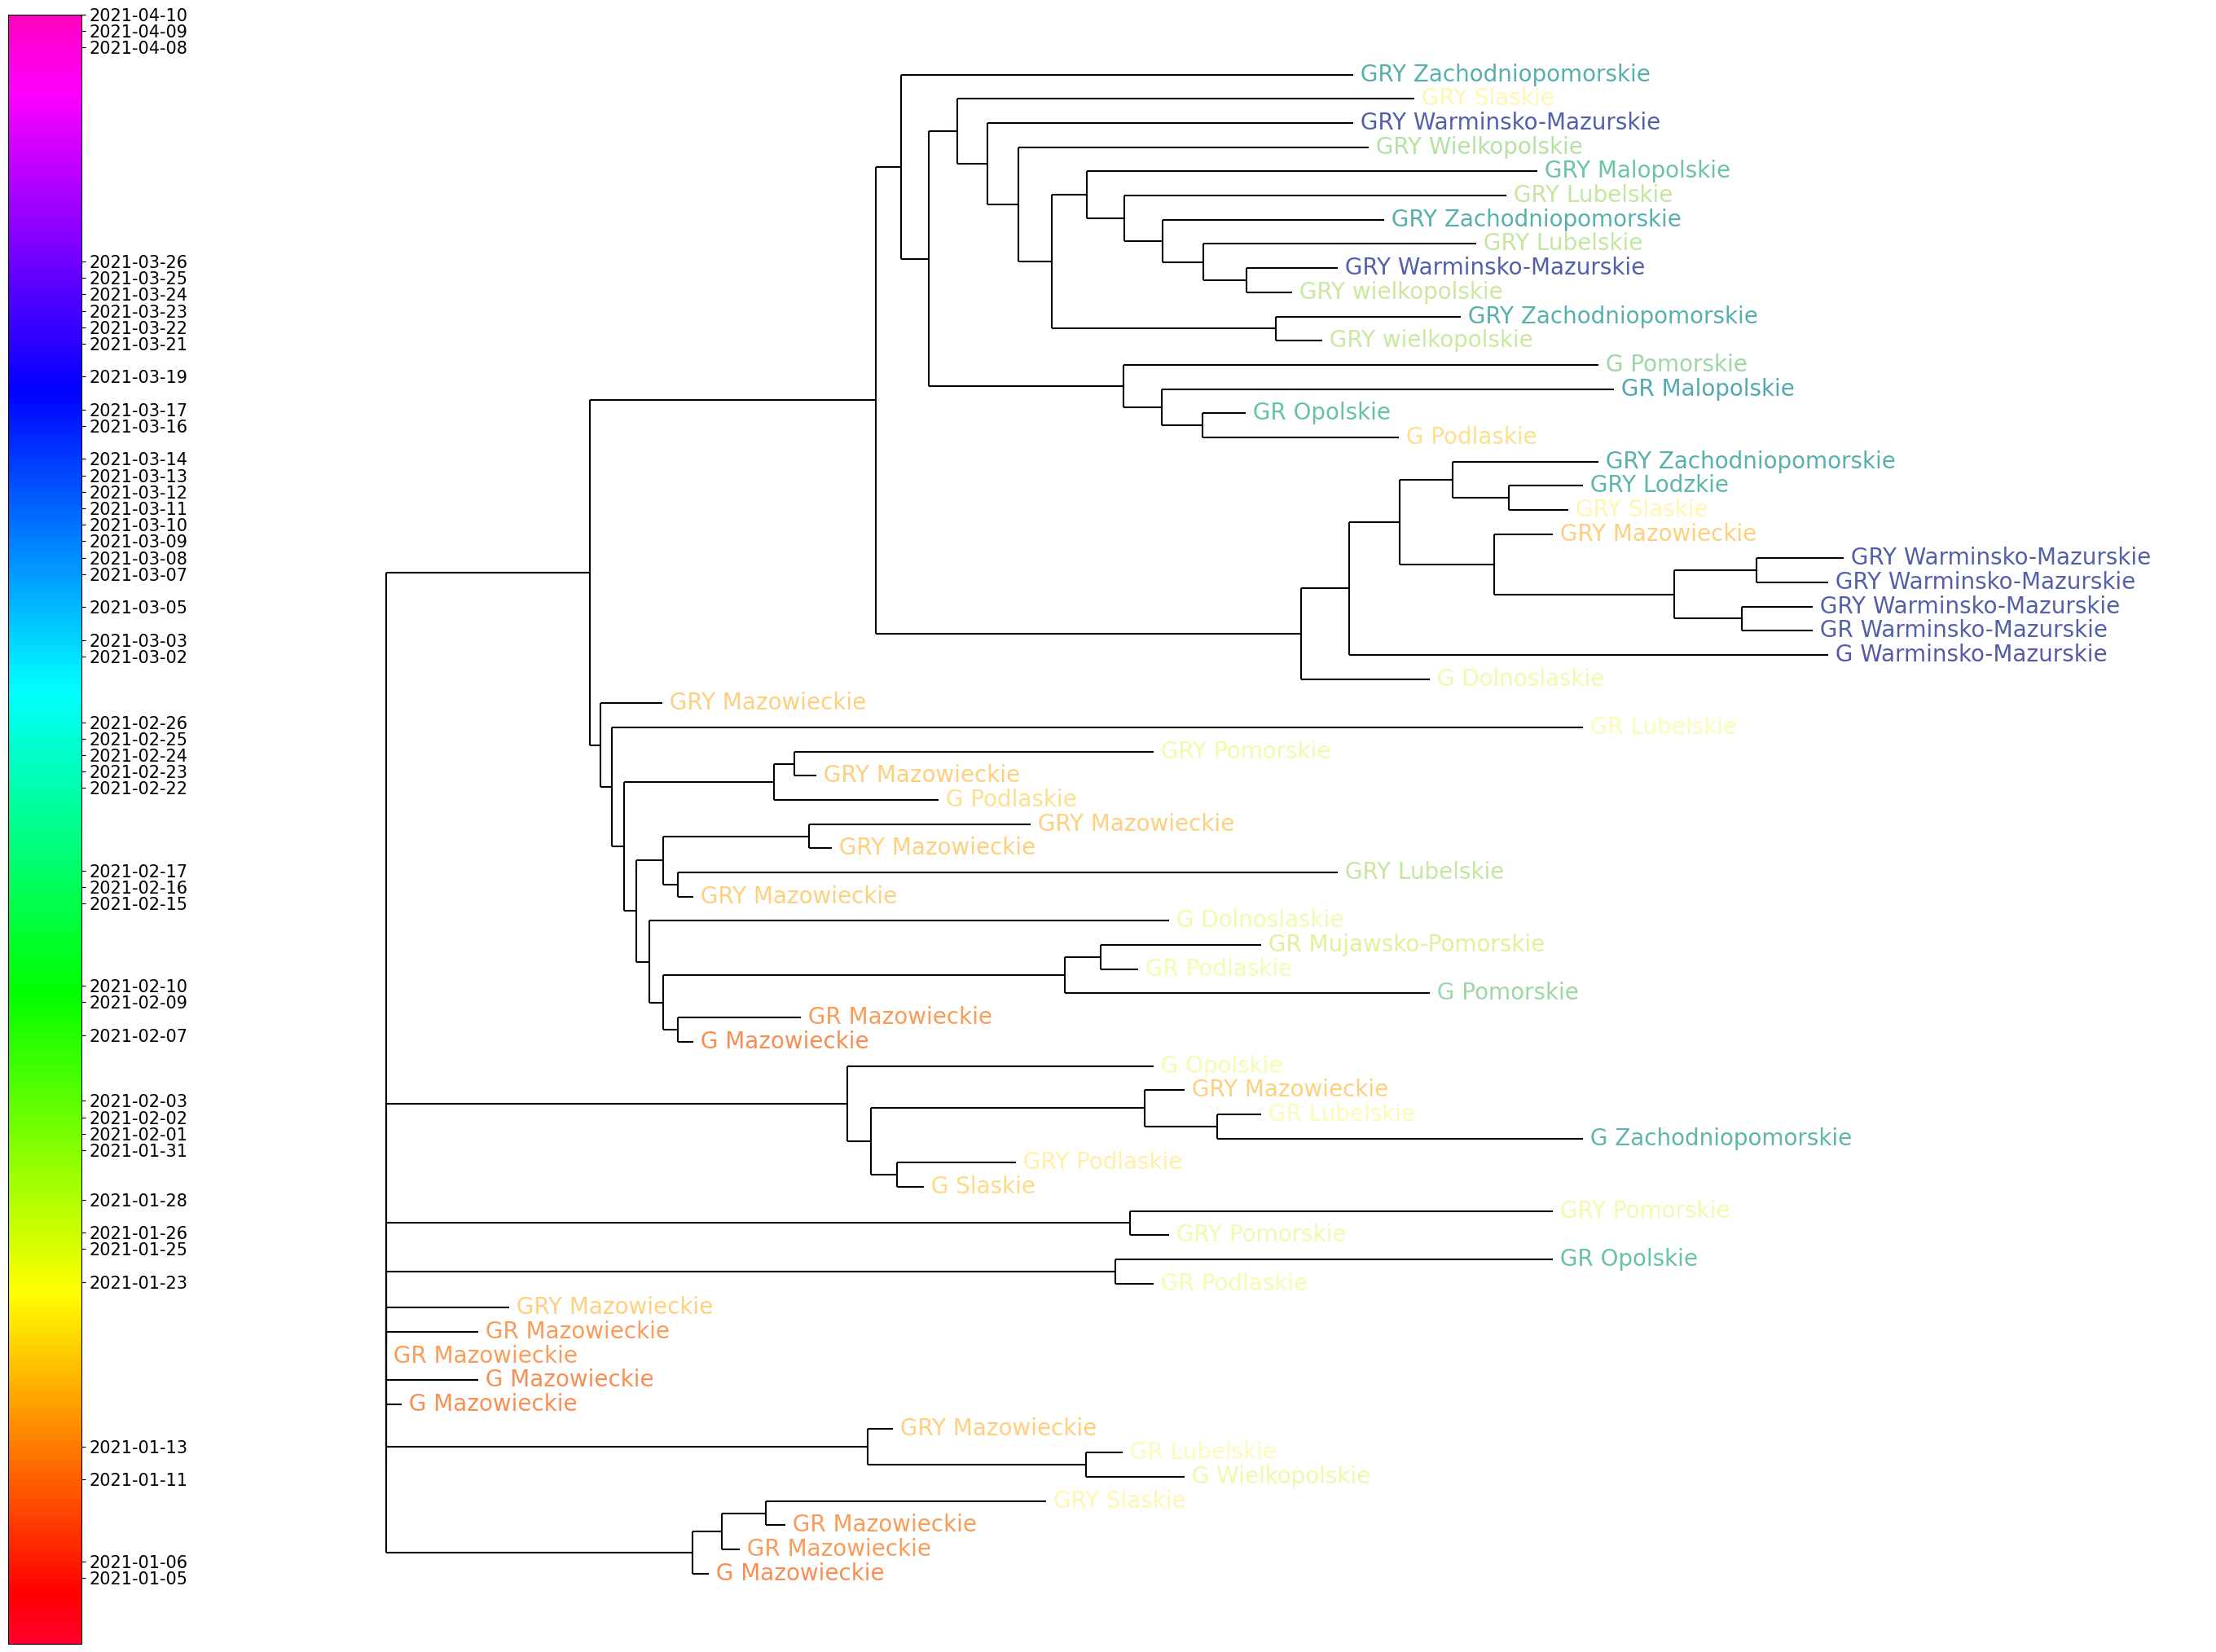

In [353]:
def labels_col2(c):
    print(c)
    try:
        date = c.split(" ")[3]
        return color_code[date]
    except IndexError:
        return "black"
    
def labels_col3(c):
    try:
        ind = c.find('Date: ')
        date = c[ind + 6: ind + 16]
        return color_code[date]
    except KeyError:
        return "black"
    
def labels(c):
    if not c.is_terminal():
        return ""
    else:
        return " ".join(c.name.split(" ")[:6])
    
def labels3(c):
    
    if not c.is_terminal():
        print(c.is_terminal())
        return ""
    else:
        s = c.name.split(' ')
        print(c.is_terminal())
        print(c)
        print(s)
        print('  '.join(s[[1,3,5]]))
        return '  '.join(s[[1,3,5]])
        

matplotlib.rc('font', size=20)
fig = plt.figure(figsize=(30, 25), dpi=100)
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree3, axes=axes, do_show=False, label_func=labels, label_colors=lc)
plt.axis('off')
# color bar
cbaxes = fig.add_axes([0, 0.1, 0.03, 0.8])
cb = fig.colorbar(cm.ScalarMappable(cmap="gist_rainbow"), cax=cbaxes)
cb.set_ticks(np.where([date_list[i] in unique_dates for i in range(len(date_list))])[0]/99)
cb.set_ticklabels(unique_dates)
font_size = 15 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
plt.savefig("./tree6.svg", format="svg", transparent=True)

In [355]:
tree3

Tree(rooted=True)

In [354]:
def foo(a, b=[]):
    b.append(a)
    return b

In [337]:
foo(3)

[3]

In [338]:
foo(4)

[3, 4]